# Autoscaling a service with Amazon SageMaker

This notebook shows an example of how to use reinforcement learning technique to address a very common problem in production operation of software systems: scaling a production service by adding and removing resources (e.g. servers or EC2 instances) in reaction to dynamically changing load. This example is a simple toy demonstrating how one might begin to address this real and challenging problem. We build up a fake simulated system with daily and weekly variations and occassional spikes. It also has a delay between when new resources are requested and when they become available for serving requests. The customized environment is constructed using Open AI gym and the RL agents are trained using Amazon SageMaker.

## Problem Statement

Autoscaling enables services to dynamically update capacity up or down automatically depending on conditions you define. Today, this requires setting up alarms, scaling policies, thresholds etc. Under the customized simulator, the RL problem for autoscaling can be defined as: 

1. *Objective*: Optimize profit of a scalable web service by adapting instance capacity to load profile. Meanwhile, ensure the servers/instances are sufficient when a spike occurs.
2. *Environment*: Custom developed environment that includes the load profile. It generates a fake simulated load with daily and weekly variations and occasional spikes. The simulated system has a delay between when new resources are requested and when they become available for serving requests.
3. *State*: A time-weighted combination of previous and current observations. At each timestamp, an observation includes current load (transactions this minute), number of failed transactions, a boolean variable indicating whether the service is in downtime (when availability drops below 99.5%), and the current number of active machines.
4. *Action*: Remove or add machines. The agent can do both at the same time.
5. *Reward*: A customized reward function based on a simple financial model. On top of positive reward for successful transactions, we take costs for running machines into consideration. We also apply a high penalty for downtime.

## Using Amazon SageMaker for RL

Amazon SageMaker allows you to train your RL agents in cloud machines using docker containers. You do not have to worry about setting up your machines with the RL toolkits and deep learning frameworks. You can easily switch between many different machines setup for you, including powerful GPU machines that give a big speedup. You can also choose to use multiple machines in a cluster to further speedup training, often necessary for production level loads.

## Pre-requisites

### Roles and permissions

To get started, we'll import the Python libraries we need, set up the environment with a few prerequisites for permissions and configurations.

In [1]:
import sagemaker
import boto3
import sys
import os
import glob
import re
import subprocess
from IPython.display import HTML
import time
from time import gmtime, strftime
sys.path.append("common")
from misc import get_execution_role, wait_for_s3_object
from sagemaker.rl import RLEstimator, RLToolkit, RLFramework

### Steup S3 buckets

Set up the linkage and authentication to the S3 bucket that you want to use for checkpoint and the metadata. 

In [2]:
# S3 bucket
sage_session = sagemaker.session.Session()
# s3_bucket = sage_session.default_bucket() # Default bucket     
s3_bucket = "aws-ml-demo-2020"
s3_output_path = 's3://{}/'.format(s3_bucket) # SDK appends the job name and output folder
print("S3 bucket path: {}".format(s3_output_path))

S3 bucket path: s3://aws-ml-demo-2020/


### Define Variables 

We define variables such as the job prefix for the training jobs *and the image path for the container (only when this is BYOC).*

In [3]:
# create unique job name 
job_name_prefix = 'rl-auto-scaling'

### Configure settings

You can run your RL training jobs on a SageMaker notebook instance or on your own machine. In both of these scenarios, you can run the following in either `local` or `SageMaker` modes. The `local` mode uses the SageMaker Python SDK to run your code in a local container before deploying to SageMaker. This can speed up iterative testing and debugging while using the same familiar Python SDK interface. You just need to set `local_mode = True`.

In [4]:
%%time

# run in local mode?
local_mode = False

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.91 µs


### Create an IAM role
Either get the execution role when running from a SageMaker notebook `role = sagemaker.get_execution_role()` or, when running from local machine, use utils method `role = get_execution_role()` to create an execution role.

In [5]:
try:
    role = sagemaker.get_execution_role()
except:
    role = get_execution_role()
    
print("Using IAM role arn: {}".format(role))

Using IAM role arn: arn:aws:iam::507922848584:role/service-role/AmazonSageMaker-ExecutionRole-20200203T105519


### Install docker for `local` mode

In order to work in `local` mode, you need to have docker installed. When running from you local machine, please make sure that you have docker or docker-compose (for local CPU machines) and nvidia-docker (for local GPU machines) installed. Alternatively, when running from a SageMaker notebook instance, you can simply run the following script to install dependenceis.

Note, you can only run a single local notebook at one time.

In [6]:
# only run from SageMaker notebook instance
if local_mode:
    !/bin/bash ./common/setup.sh

## Set up the environment

The environment is defined in a Python file called `autoscalesim.py` and the file is uploaded on `/src` directory. 

The environment also implements the `init()`, `step()` and `reset()` functions that describe how the environment behaves. This is consistent with Open AI Gym interfaces for defining an environment. 


1. init() - initialize the environment in a pre-defined state
2. step() - take an action on the environment
3. reset()- restart the environment on a new episode
4. [if applicable] render() - get a rendered image of the environment in its current state

In [7]:
!pygmentize src/autoscalesim.py

import numpy as np
import gym
from gym.spaces import Discrete, Box
from gym.envs.registration import EnvSpec
from gymhelper import box_space_from_description


class MultiEma():
    """Utility class that handles multiple streams of exponential moving average (EMA)
    with multiple different alpha values.
    """
    def __init__(self, num_streams, alphas):
        self.alphas = np.asarray(alphas)
        self.num_alphas = self.alphas.shape[0]
        self.num_streams = num_streams
        self.values = np.zeros(shape=(self.num_streams, self.num_alphas))

    def update(self, current):
        """Takes a vector of current observations.  Updates all the EMA streams,
        and returns them in a (N,A) matrix for the N streams and A alpha values.
        """
        decayed = self.values * (1.0 - self.alphas)
        updates = np.outer(np.asarray(current), self.alphas)
        self.values = decayed + updates
        return self.values

class SimpleScalableWebserviceSim(gym.Env):
    """A

### Visualize the simulated load

The shape of the simulated load is critical to an auto-scaling simulation. We use the this toy load simulator for visualization. The simulator has two components to load: periodic load and spikes. The periodic load is a simple daily cycle of fixed mean & amplitude, with multiplicative gaussian noise. The spike load start instantly and decay linearly until gone, and have a variable random delay between them.

In [8]:
# if open AI Gym is not installed
! pip install gym

     |████████████████████████████████| 1.6 MB 10.2 MB/s eta 0:00:01     |██████▉                         | 337 kB 10.2 MB/s eta 0:00:01
     |████████████████████████████████| 1.0 MB 60.4 MB/s eta 0:00:01
  Created wheel for gym: filename=gym-0.17.3-py3-none-any.whl size=1654654 sha256=5312bee800350a9497c3c68e547b7e43004dac15414d45d3847e87948473da4c
  Stored in directory: /home/ec2-user/.cache/pip/wheels/95/b0/62/af38051b97354eab5b2ff9a5fb92f5015a480745568c91e0b0
Successfully built gym
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow_p36/bin/python -m pip install --upgrade pip' command.


In [9]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
sys.path.append('src')
import autoscalesim

In [10]:
def xy_data(days_to_simulate=3):
    loadsim = autoscalesim.LoadSimulator()
    load = []
    x = np.arange(0, days_to_simulate, 1.0/(24*60))
    for t in x:
        load.append(loadsim.time_step_load())
    load = np.asarray(load)
    return (x, load)

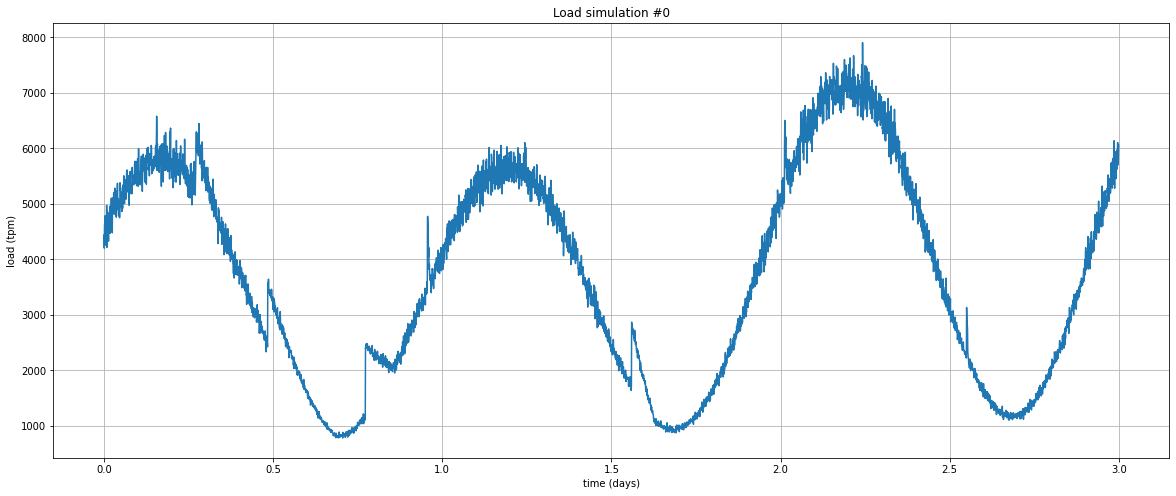

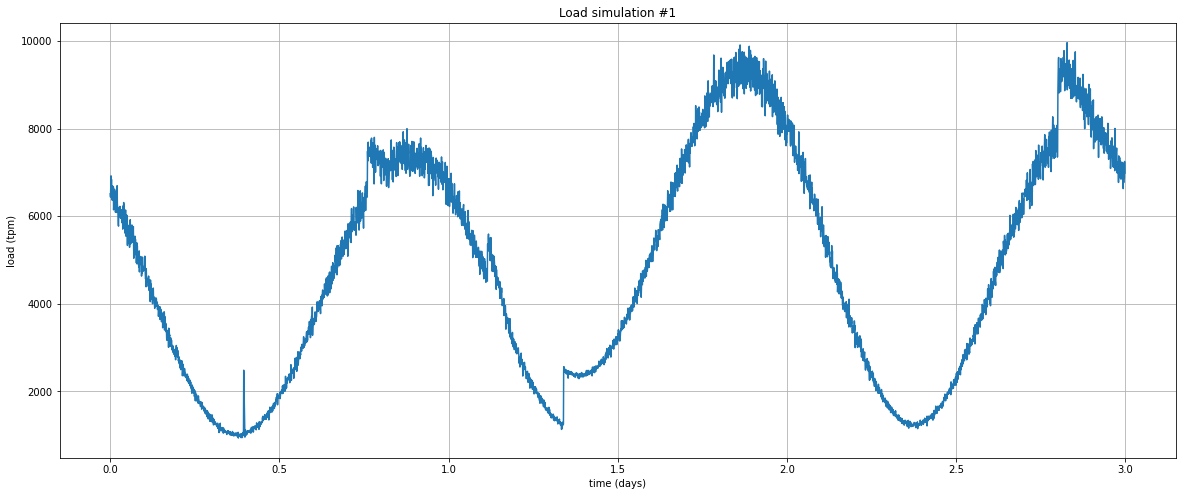

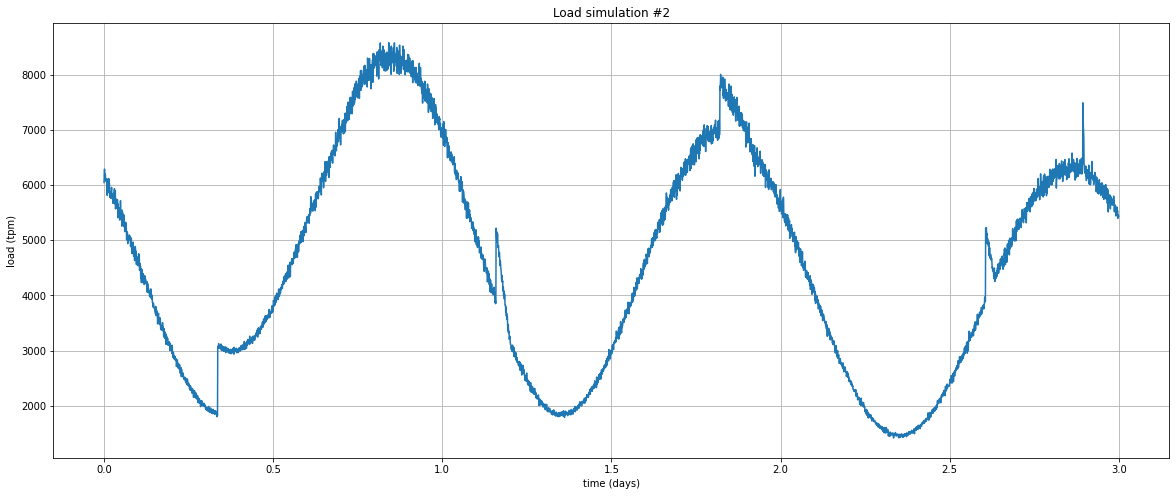

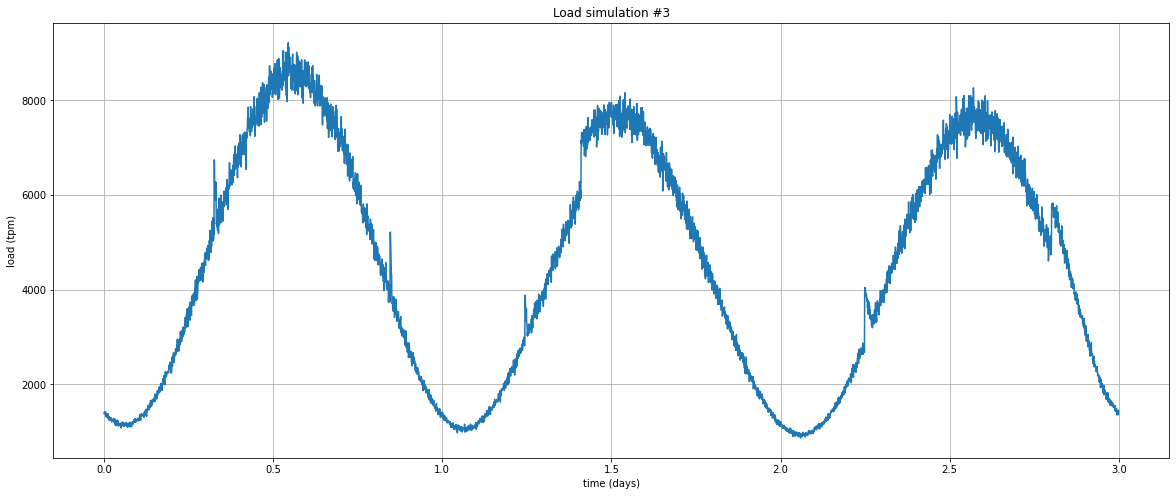

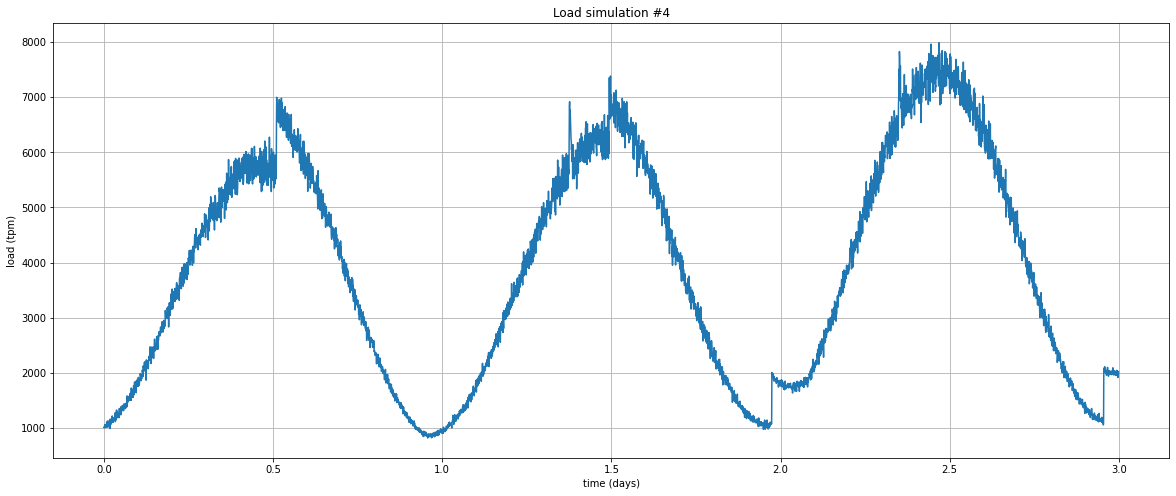

In [11]:
plt.rcParams["figure.figsize"] = (20,8)

for n in range(5):  # Draw 5 plots
    (x,y) = xy_data()
    fig, ax = plt.subplots()
    ax.plot(x, y)
    ax.set(xlabel='time (days)', ylabel='load (tpm)',
           title='Load simulation #%d' % n)
    ax.grid()
    plt.show()

## Configure the presets for RL algorithm 

The presets that configure the RL training jobs are defined in the `preset-autoscale-ppo.py` file which is also uploaded on the `/src` directory. Using the preset file, you can define agent parameters to select the specific agent algorithm. You can also set the environment parameters, define the schedule and visualization parameters, and define the graph manager. The schedule presets will define the number of heat up steps, periodic evaluation steps, training steps between evaluations.

These can be overridden at runtime by specifying the `RLCOACH_PRESET` hyperparameter. Additionally, it can be used to define custom hyperparameters. 

In [12]:
!pygmentize src/preset-autoscale-ppo.py

from rl_coach.agents.clipped_ppo_agent import ClippedPPOAgentParameters
from rl_coach.architectures.layers import Dense
from rl_coach.base_parameters import VisualizationParameters, PresetValidationParameters, DistributedCoachSynchronizationType
from rl_coach.core_types import TrainingSteps, EnvironmentEpisodes, EnvironmentSteps, RunPhase
from rl_coach.environments.gym_environment import GymVectorEnvironment, mujoco_v2
from rl_coach.exploration_policies.e_greedy import EGreedyParameters
from rl_coach.graph_managers.basic_rl_graph_manager import BasicRLGraphManager
from rl_coach.graph_managers.graph_manager import ScheduleParameters
from rl_coach.schedules import LinearSchedule

####################
# Graph Scheduling #
####################

schedule_params = ScheduleParameters()
schedule_params.improve_steps = TrainingSteps(int(5e5))
schedule_params.steps_between_evaluation_periods = EnvironmentSteps(50000)
schedule_params.evaluation_steps = EnvironmentEpisodes(5)
schedule_params.heatu

## Write the Training Code 

The training code is written in the file “train-coach.py” which is uploaded in the /src directory. 
First import the environment files and the preset files, and then define the `main()` function. 

In [13]:
!pygmentize src/train-coach.py

from sagemaker_rl.coach_launcher import SageMakerCoachPresetLauncher
import tensorflow as tf
import shutil

class MyLauncher(SageMakerCoachPresetLauncher):

    def default_preset_name(self):
        """This points to a .py file that configures everything about the RL job.
        It can be overridden at runtime by specifying the RLCOACH_PRESET hyperparameter.
        """
        return 'preset-autoscale-ppo'

    def map_hyperparameter(self, name, value):
        """Here we configure some shortcut names for hyperparameters that we expect to use frequently.
        Essentially anything in the preset file can be overridden through a hyperparameter with a name 
        like "rl.agent_params.algorithm.etc".  
        """
        if name == "warmup_latency":
            return self.apply_hyperparameter("rl.env_params.additional_simulator_parameters.warmup_latency", value)
        if name == "discount": 
            return self.apply_hyperparameter("rl.agent_params.algorithm.discount", valu

In [14]:
%%time

if local_mode:
    instance_type = 'local'
else:
    instance_type = "ml.m4.xlarge"
        
estimator = RLEstimator(entry_point="train-coach.py",
                        source_dir='src',
                        dependencies=["common/sagemaker_rl"],
                        toolkit=RLToolkit.COACH,
                        toolkit_version='0.11.0',
                        framework=RLFramework.TENSORFLOW,
                        role=role,
                        train_instance_type=instance_type,
                        train_instance_count=1,
                        output_path=s3_output_path,
                        base_job_name=job_name_prefix,
                        hyperparameters = {
                          "RLCOACH_PRESET": "preset-autoscale-ppo",
                          "rl.agent_params.algorithm.discount": 0.9,
                          "rl.evaluation_steps:EnvironmentEpisodes": 8,
                          # save model for deployment
                          "save_model": 1
                        }
                    )
estimator.fit()

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


2020-11-10 10:10:19 Starting - Starting the training job...
2020-11-10 10:10:22 Starting - Launching requested ML instances......
2020-11-10 10:11:38 Starting - Preparing the instances for training......
2020-11-10 10:12:33 Downloading - Downloading input data...
2020-11-10 10:13:19 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-11-10 10:13:21,093 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2020-11-10 10:13:21,097 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-11-10 10:13:21,273 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-11-10 10:13:21,287 sagemaker-containers INFO     Invoking user script

Training Env:

{
    "additional_framework_parameters": {
        "sagemaker_estimator": "RLEstimator"
    },
    "channel_input_dirs": {},
    "

Heatup> Name=main_level/agent, Worker=0, Episode=1, Total reward=-124936.38, Steps=10001, Training iteration=0
Heatup> Name=main_level/agent, Worker=0, Episode=2, Total reward=-171025.65, Steps=20002, Training iteration=0
Heatup> Name=main_level/agent, Worker=0, Episode=3, Total reward=-170814.9, Steps=30003, Training iteration=0
Heatup> Name=main_level/agent, Worker=0, Episode=4, Total reward=-111076.01, Steps=40004, Training iteration=0
Heatup> Name=main_level/agent, Worker=0, Episode=5, Total reward=-129818.96, Steps=50005, Training iteration=0
Heatup> Name=main_level/agent, Worker=0, Episode=6, Total reward=-116961.68, Steps=60006, Training iteration=0
Heatup> Name=main_level/agent, Worker=0, Episode=7, Total reward=-104441.83, Steps=70007, Training iteration=0
Heatup> Name=main_level/agent, Worker=0, Episode=8, Total reward=-51356.13, Steps=80008, Training iteration=0
Heatup> Name=main_level/agent, Worker=0, Episode=9, Total reward=-133170.0, Steps=90009, Training iteration=0
Heat

## agent: Starting evaluation phase
Testing> Name=main_level/agent, Worker=0, Episode=19, Total reward=16868.67, Steps=200015, Training iteration=4
Testing> Name=main_level/agent, Worker=0, Episode=19, Total reward=13340.24, Steps=200015, Training iteration=4
Testing> Name=main_level/agent, Worker=0, Episode=19, Total reward=8414.15, Steps=200015, Training iteration=4
Testing> Name=main_level/agent, Worker=0, Episode=19, Total reward=5999.43, Steps=200015, Training iteration=4
Testing> Name=main_level/agent, Worker=0, Episode=19, Total reward=10739.95, Steps=200015, Training iteration=4
Testing> Name=main_level/agent, Worker=0, Episode=19, Total reward=15916.03, Steps=200015, Training iteration=4
Testing> Name=main_level/agent, Worker=0, Episode=19, Total reward=-104359.73, Steps=200015, Training iteration=4
Testing> Name=main_level/agent, Worker=0, Episode=19, Total reward=10893.78, Steps=200015, Training iteration=4
## agent: Finished evaluation phase. Success rate = 0.0, Avg Total R

## agent: Starting evaluation phase
Testing> Name=main_level/agent, Worker=0, Episode=23, Total reward=-218543.91, Steps=250015, Training iteration=8
Testing> Name=main_level/agent, Worker=0, Episode=23, Total reward=-256892.67, Steps=250015, Training iteration=8
Testing> Name=main_level/agent, Worker=0, Episode=23, Total reward=-268293.1, Steps=250015, Training iteration=8
Testing> Name=main_level/agent, Worker=0, Episode=23, Total reward=-256083.71, Steps=250015, Training iteration=8
Testing> Name=main_level/agent, Worker=0, Episode=23, Total reward=-269028.74, Steps=250015, Training iteration=8
Testing> Name=main_level/agent, Worker=0, Episode=23, Total reward=-259000.96, Steps=250015, Training iteration=8
Testing> Name=main_level/agent, Worker=0, Episode=23, Total reward=-260984.23, Steps=250015, Training iteration=8
Testing> Name=main_level/agent, Worker=0, Episode=23, Total reward=-292784.63, Steps=250015, Training iteration=8
## agent: Finished evaluation phase. Success rate = 0

## agent: Starting evaluation phase
Testing> Name=main_level/agent, Worker=0, Episode=27, Total reward=-284757.78, Steps=300015, Training iteration=12
Testing> Name=main_level/agent, Worker=0, Episode=27, Total reward=-278331.82, Steps=300015, Training iteration=12
Testing> Name=main_level/agent, Worker=0, Episode=27, Total reward=-286544.24, Steps=300015, Training iteration=12
Testing> Name=main_level/agent, Worker=0, Episode=27, Total reward=-273366.13, Steps=300015, Training iteration=12
Testing> Name=main_level/agent, Worker=0, Episode=27, Total reward=-269020.43, Steps=300015, Training iteration=12
Testing> Name=main_level/agent, Worker=0, Episode=27, Total reward=-288607.33, Steps=300015, Training iteration=12
Testing> Name=main_level/agent, Worker=0, Episode=27, Total reward=-272965.09, Steps=300015, Training iteration=12
Testing> Name=main_level/agent, Worker=0, Episode=27, Total reward=-276850.22, Steps=300015, Training iteration=12
## agent: Finished evaluation phase. Success

## agent: Starting evaluation phase
Testing> Name=main_level/agent, Worker=0, Episode=31, Total reward=-46839.03, Steps=350015, Training iteration=16
Testing> Name=main_level/agent, Worker=0, Episode=31, Total reward=-4680.98, Steps=350015, Training iteration=16
Testing> Name=main_level/agent, Worker=0, Episode=31, Total reward=760.87, Steps=350015, Training iteration=16
Testing> Name=main_level/agent, Worker=0, Episode=31, Total reward=-2756.42, Steps=350015, Training iteration=16
Testing> Name=main_level/agent, Worker=0, Episode=31, Total reward=-2550.09, Steps=350015, Training iteration=16
Testing> Name=main_level/agent, Worker=0, Episode=31, Total reward=-9257.44, Steps=350015, Training iteration=16
Testing> Name=main_level/agent, Worker=0, Episode=31, Total reward=-2399.0, Steps=350015, Training iteration=16
Testing> Name=main_level/agent, Worker=0, Episode=31, Total reward=-7325.07, Steps=350015, Training iteration=16
## agent: Finished evaluation phase. Success rate = 0.0, Avg T

Checkpoint> Saving in path=['/opt/ml/output/data/checkpoint/28_Step-246089.ckpt']
## agent: Starting evaluation phase
Testing> Name=main_level/agent, Worker=0, Episode=35, Total reward=-261713.34, Steps=400015, Training iteration=20
Testing> Name=main_level/agent, Worker=0, Episode=35, Total reward=-246181.21, Steps=400015, Training iteration=20
Testing> Name=main_level/agent, Worker=0, Episode=35, Total reward=-267359.23, Steps=400015, Training iteration=20
Testing> Name=main_level/agent, Worker=0, Episode=35, Total reward=-261948.55, Steps=400015, Training iteration=20
Testing> Name=main_level/agent, Worker=0, Episode=35, Total reward=-267443.18, Steps=400015, Training iteration=20
Testing> Name=main_level/agent, Worker=0, Episode=35, Total reward=-235557.58, Steps=400015, Training iteration=20
Testing> Name=main_level/agent, Worker=0, Episode=35, Total reward=-267696.34, Steps=400015, Training iteration=20
Testing> Name=main_level/agent, Worker=0, Episode=35, Total reward=-260048.93

## agent: Starting evaluation phase
Testing> Name=main_level/agent, Worker=0, Episode=39, Total reward=-223320.5, Steps=450015, Training iteration=24
Testing> Name=main_level/agent, Worker=0, Episode=39, Total reward=-214042.8, Steps=450015, Training iteration=24
Testing> Name=main_level/agent, Worker=0, Episode=39, Total reward=-239714.77, Steps=450015, Training iteration=24
Testing> Name=main_level/agent, Worker=0, Episode=39, Total reward=-242275.52, Steps=450015, Training iteration=24
Testing> Name=main_level/agent, Worker=0, Episode=39, Total reward=-241971.62, Steps=450015, Training iteration=24
Testing> Name=main_level/agent, Worker=0, Episode=39, Total reward=-247601.72, Steps=450015, Training iteration=24
Testing> Name=main_level/agent, Worker=0, Episode=39, Total reward=-191119.07, Steps=450015, Training iteration=24
Testing> Name=main_level/agent, Worker=0, Episode=39, Total reward=-220381.71, Steps=450015, Training iteration=24
## agent: Finished evaluation phase. Success r

## agent: Starting evaluation phase
Testing> Name=main_level/agent, Worker=0, Episode=43, Total reward=-142231.24, Steps=500015, Training iteration=28
Testing> Name=main_level/agent, Worker=0, Episode=43, Total reward=-168872.63, Steps=500015, Training iteration=28
Testing> Name=main_level/agent, Worker=0, Episode=43, Total reward=-207015.76, Steps=500015, Training iteration=28
Testing> Name=main_level/agent, Worker=0, Episode=43, Total reward=-152868.21, Steps=500015, Training iteration=28
Testing> Name=main_level/agent, Worker=0, Episode=43, Total reward=-156653.72, Steps=500015, Training iteration=28
Testing> Name=main_level/agent, Worker=0, Episode=43, Total reward=-107744.93, Steps=500015, Training iteration=28
Testing> Name=main_level/agent, Worker=0, Episode=43, Total reward=-137380.59, Steps=500015, Training iteration=28
Testing> Name=main_level/agent, Worker=0, Episode=43, Total reward=-182161.28, Steps=500015, Training iteration=28
## agent: Finished evaluation phase. Success

Checkpoint> Saving in path=['/opt/ml/output/data/checkpoint/45_Step-399994.ckpt']
## agent: Starting evaluation phase
Testing> Name=main_level/agent, Worker=0, Episode=47, Total reward=-202389.28, Steps=550015, Training iteration=32
Testing> Name=main_level/agent, Worker=0, Episode=47, Total reward=-205446.0, Steps=550015, Training iteration=32
Testing> Name=main_level/agent, Worker=0, Episode=47, Total reward=-205788.39, Steps=550015, Training iteration=32
Testing> Name=main_level/agent, Worker=0, Episode=47, Total reward=-170802.02, Steps=550015, Training iteration=32
Testing> Name=main_level/agent, Worker=0, Episode=47, Total reward=-199431.63, Steps=550015, Training iteration=32
Testing> Name=main_level/agent, Worker=0, Episode=47, Total reward=-158045.3, Steps=550015, Training iteration=32
Testing> Name=main_level/agent, Worker=0, Episode=47, Total reward=-196462.8, Steps=550015, Training iteration=32
Testing> Name=main_level/agent, Worker=0, Episode=47, Total reward=-160498.69, S

## agent: Starting evaluation phase
Testing> Name=main_level/agent, Worker=0, Episode=51, Total reward=-202175.31, Steps=600015, Training iteration=36
Testing> Name=main_level/agent, Worker=0, Episode=51, Total reward=-150519.1, Steps=600015, Training iteration=36
Testing> Name=main_level/agent, Worker=0, Episode=51, Total reward=-189936.26, Steps=600015, Training iteration=36
Testing> Name=main_level/agent, Worker=0, Episode=51, Total reward=-193192.64, Steps=600015, Training iteration=36
Testing> Name=main_level/agent, Worker=0, Episode=51, Total reward=-169439.61, Steps=600015, Training iteration=36
Testing> Name=main_level/agent, Worker=0, Episode=51, Total reward=-194198.48, Steps=600015, Training iteration=36
Testing> Name=main_level/agent, Worker=0, Episode=51, Total reward=-195816.28, Steps=600015, Training iteration=36
Testing> Name=main_level/agent, Worker=0, Episode=51, Total reward=-197143.19, Steps=600015, Training iteration=36
## agent: Finished evaluation phase. Success 

Checkpoint> Saving in path=['/opt/ml/output/data/checkpoint/57_Step-499988.ckpt']
## agent: Starting evaluation phase
Testing> Name=main_level/agent, Worker=0, Episode=55, Total reward=-136726.38, Steps=650015, Training iteration=40
Testing> Name=main_level/agent, Worker=0, Episode=55, Total reward=-194946.81, Steps=650015, Training iteration=40
Testing> Name=main_level/agent, Worker=0, Episode=55, Total reward=-192386.0, Steps=650015, Training iteration=40
Testing> Name=main_level/agent, Worker=0, Episode=55, Total reward=-186123.13, Steps=650015, Training iteration=40
Testing> Name=main_level/agent, Worker=0, Episode=55, Total reward=-164994.71, Steps=650015, Training iteration=40
Testing> Name=main_level/agent, Worker=0, Episode=55, Total reward=-159074.28, Steps=650015, Training iteration=40
Testing> Name=main_level/agent, Worker=0, Episode=55, Total reward=-182137.68, Steps=650015, Training iteration=40
Testing> Name=main_level/agent, Worker=0, Episode=55, Total reward=-226730.72,

## Store intermediate training output and model checkpoints 

The output from the training job above is either stored in a local directory (`local` mode) or on S3 (`SageMaker`) mode.


In [15]:
%%time

job_name=estimator._current_job_name
print("Job name: {}".format(job_name))

s3_url = "s3://{}/{}".format(s3_bucket,job_name)

if local_mode:
    output_tar_key = "{}/output.tar.gz".format(job_name)
else:
    output_tar_key = "{}/output/output.tar.gz".format(job_name)

intermediate_folder_key = "{}/output/intermediate/".format(job_name)
output_url = "s3://{}/{}".format(s3_bucket, output_tar_key)
intermediate_url = "s3://{}/{}".format(s3_bucket, intermediate_folder_key)

print("S3 job path: {}".format(s3_url))
print("Output.tar.gz location: {}".format(output_url))
print("Intermediate folder path: {}".format(intermediate_url))
    
tmp_dir = "/tmp/{}".format(job_name)
os.system("mkdir {}".format(tmp_dir))
print("Create local folder {}".format(tmp_dir))

Job name: rl-auto-scaling-2020-11-10-10-10-18-974
S3 job path: s3://aws-ml-demo-2020/rl-auto-scaling-2020-11-10-10-10-18-974
Output.tar.gz location: s3://aws-ml-demo-2020/rl-auto-scaling-2020-11-10-10-10-18-974/output/output.tar.gz
Intermediate folder path: s3://aws-ml-demo-2020/rl-auto-scaling-2020-11-10-10-10-18-974/output/intermediate/
Create local folder /tmp/rl-auto-scaling-2020-11-10-10-10-18-974
CPU times: user 3.26 ms, sys: 4.47 ms, total: 7.73 ms
Wall time: 9.64 ms


## Visualization

### Plot rate of learning

We can view the rewards during training using the code below. This visualization helps us understand how the performance of the model represented as the reward has improved over time.

Waiting for s3://aws-ml-demo-2020/rl-auto-scaling-2020-11-10-10-10-18-974/output/intermediate/worker_0.simple_rl_graph.main_level.main_level.agent_0.csv...


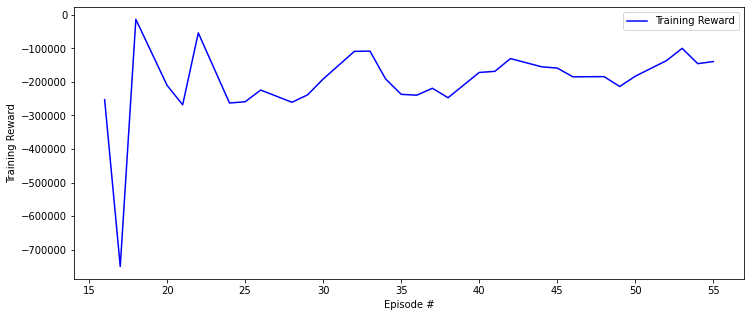

In [16]:
%matplotlib inline
import pandas as pd

csv_file_name = "worker_0.simple_rl_graph.main_level.main_level.agent_0.csv"
key = os.path.join(intermediate_folder_key, csv_file_name)
wait_for_s3_object(s3_bucket, key, tmp_dir)

csv_file = "{}/{}".format(tmp_dir, csv_file_name)
df = pd.read_csv(csv_file)
df = df.dropna(subset=['Training Reward'])
x_axis = 'Episode #'
y_axis = 'Training Reward'

plt = df.plot(x=x_axis,y=y_axis, figsize=(12,5), legend=True, style='b-')
plt.set_ylabel(y_axis);
plt.set_xlabel(x_axis);

## Evaluation of RL models

We use the latest checkpointed model to run evaluation for the RL Agent. 

### Load the checkpointed models 

Checkpointed data from the previously trained models will be passed on for evaluation / inference in the `checkpoint` channel. In `local` mode, we can simply use the local directory, whereas in the `SageMaker` mode, it needs to be moved to S3 first.

Since TensorFlow stores ckeckpoint file containes absolute paths from when they were generated (see [issue](https://github.com/tensorflow/tensorflow/issues/9146)), we need to replace the absolute paths to relative paths. This is implemented within `evaluate-coach.py`

In [17]:
%%time

wait_for_s3_object(s3_bucket, output_tar_key, tmp_dir)  

if not os.path.isfile("{}/output.tar.gz".format(tmp_dir)):
    raise FileNotFoundError("File output.tar.gz not found")
os.system("tar -xvzf {}/output.tar.gz -C {}".format(tmp_dir, tmp_dir))

if local_mode:
    checkpoint_dir = "{}/data/checkpoint".format(tmp_dir)
else:
    checkpoint_dir = "{}/checkpoint".format(tmp_dir)

print("Checkpoint directory {}".format(checkpoint_dir))

Waiting for s3://aws-ml-demo-2020/rl-auto-scaling-2020-11-10-10-10-18-974/output/output.tar.gz...
Checkpoint directory /tmp/rl-auto-scaling-2020-11-10-10-10-18-974/checkpoint
CPU times: user 113 ms, sys: 29.7 ms, total: 143 ms
Wall time: 1.37 s


In [18]:
%%time

if local_mode:
    checkpoint_path = 'file://{}'.format(checkpoint_dir)
    print("Local checkpoint file path: {}".format(checkpoint_path))
else:
    checkpoint_path = "s3://{}/{}/checkpoint/".format(s3_bucket, job_name)
    if not os.listdir(checkpoint_dir):
        raise FileNotFoundError("Checkpoint files not found under the path")
    os.system("aws s3 cp --recursive {} {}".format(checkpoint_dir, checkpoint_path))
    print("S3 checkpoint file path: {}".format(checkpoint_path))

S3 checkpoint file path: s3://aws-ml-demo-2020/rl-auto-scaling-2020-11-10-10-10-18-974/checkpoint/
CPU times: user 1.19 ms, sys: 4.36 ms, total: 5.55 ms
Wall time: 2.65 s


### Run the evaluation step

Use the checkpointed model to run the evaluation step. 

In [20]:
%%time

estimator_eval = RLEstimator(role=role,
                      source_dir='src/',
                      dependencies=["common/sagemaker_rl"],
                      toolkit=RLToolkit.COACH,
                      toolkit_version='0.11.0',
                      framework=RLFramework.TENSORFLOW,
                      entry_point="evaluate-coach.py",
                      train_instance_count=1,
                      train_instance_type=instance_type,
                      hyperparameters = {
                                 "RLCOACH_PRESET": "preset-autoscale-ppo",
                                 "evaluate_steps": 10001*2 # evaluate on 2 episodes
                             }
                    )
estimator_eval.fit({'checkpoint': checkpoint_path})

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


2020-11-11 04:06:38 Starting - Starting the training job...
2020-11-11 04:06:40 Starting - Launching requested ML instances.........
2020-11-11 04:08:15 Starting - Preparing the instances for training......
2020-11-11 04:09:24 Downloading - Downloading input data...
2020-11-11 04:09:50 Training - Downloading the training image.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-11-11 04:10:12,885 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2020-11-11 04:10:12,889 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)

2020-11-11 04:10:10 Training - Training image download completed. Training in progress.2020-11-11 04:10:28,443 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-11-11 04:10:28,457 sagemaker-containers INFO     Invoking user script

Training Env:

{
    "additional_framework_parameters": {
        "sagemaker_est

Testing> Name=main_level/agent, Worker=0, Episode=1, Total reward=-33959.9, Steps=10001, Training iteration=0

2020-11-11 04:11:07 Uploading - Uploading generated training modelTesting> Name=main_level/agent, Worker=0, Episode=2, Total reward=-130695.09, Steps=20002, Training iteration=0
## agent: Finished evaluation phase. Success rate = 0.0, Avg Total Reward = -82327.5
2020-11-11 04:11:03,543 sagemaker-containers INFO     Reporting training SUCCESS

2020-11-11 04:11:15 Completed - Training job completed
Training seconds: 111
Billable seconds: 111
CPU times: user 816 ms, sys: 47 ms, total: 863 ms
Wall time: 5min 15s


## Hosting

Once the training is done, we can deploy the trained model as an Amazon SageMaker real-time hosted endpoint. This will allow us to make predictions (or inference) from the model. Note that we don't have to host on the same insantance (or type of instance) that we used to train. The endpoint deployment can be accomplished as follows:

In [21]:
predictor = estimator.deploy(initial_instance_count=1, instance_type='ml.c5.xlarge')

update_endpoint is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


-----------!

### Inference

Now that the trained model is deployed at an endpoint that is up-and-running, we can use this endpoint for inference. The format of input should match that of `observation_space` in the defined environment. In this example, the observation space is a 25 dimensional vector formulated from previous and current observations. For the sake of space, this demo doesn't include the non-trivial construction process. Instead, we provide a dummy input below. For more details, please check `src/autoscalesim.py`. 

In [22]:
observation = np.arange(1, 26)
action = predictor.predict(observation)
print(action)

{'predictions': [[0.00440965, -0.00386934]]}


### Delete the Endpoint
Having an endpoint running will incur some costs. Therefore as a clean-up job, we should delete the endpoint.

In [ ]:
#predictor.delete_endpoint()